In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from numba import cuda
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim



from tqdm import tqdm


In [2]:
device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cuda


## Function we want to learn

In [3]:
E0 = 500

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def f(x): # 1st order approximation to the function

    alpha_s_scale = alpha_s(x * E0) # GeV
    C_F = 4/3
    C_A = 3

    return -(alpha_s_scale * C_F / (1 * np.pi)) * torch.log(x ) / x


In [4]:
# Custom Loss

def custom_loss(y_pred, y_true, data):
    
    # data = [x, lambda_cutoff]
    
    # MATCHING LOSS
    # We want to match the prediction to the true value only if x > Lambda
    # Last value of y_pred is lamba
    acceptable_error = (alpha_s(data[:-1] * E0)**2)/(2*np.pi)**2
    
    
    mask = data[:-1] > data[-1]
    matching_loss = torch.mean(mask * (y_true - y_pred[:-1])**2 / acceptable_error)
    
    # GRADIENT LOSS
    # The network should depend on lambda nowhere
    dmodel_dlambda = torch.autograd.grad(y_pred, data, retain_graph=True, grad_outputs=torch.ones_like(y_pred))[0][-1] 
    gradient_loss = 1*torch.abs(dmodel_dlambda)
    
    # NORMALIZATION LOSS
    lagrange_mult = 100
    
    normalization_loss = lagrange_mult*(torch.sum(y_pred[:-1])*(data[1]-data[0]) - 1)**2
    normalization_loss = 0

    return matching_loss + gradient_loss + normalization_loss


In [5]:



def np_to_torch(array, device):
    
    return torch.tensor(array.astype(np.float32)).to(device)
    
"""
NEURAL NET
"""

class NeuralNet(nn.Module):
    def __init__(self, input_shape):
        super(NeuralNet, self).__init__()

        # First fully connected layer
        self.fc1 = nn.Linear(input_shape, 32) # first size is output of flatten
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

        
    # x represents our data
    def forward(self, x):

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    



In [6]:
lr = 0.001
num_points = 1024
n_epochs = 20
num_instantiations = 20

num_models = 5
losses = {i:[] for i in range(num_models)}
dense_nets = {i:[] for i in range(num_models)}

for i in range(num_models):

    dense_nets[i] = NeuralNet(input_shape = 1)
    optimizer = torch.optim.Adam(dense_nets[i].parameters(), lr=lr)
    dense_nets[i].to(device)

    for epoch in tqdm(range(n_epochs)):
        
        epoch_losses = 0
        
        for j in range(num_instantiations):
        
            # generate the data
            batch_x = np.linspace(0.001, 1, num_points).reshape(-1,1)
            batch_x = np_to_torch(batch_x, device)
            batch_y = f(batch_x)
            

            batch_lambda_cutoff = 1.0-torch.rand((1,1), device = device)*.8

            batch_data = torch.cat([batch_x, batch_lambda_cutoff])
            batch_data.requires_grad_()


            optimizer.zero_grad()
            loss = custom_loss(dense_nets[i](batch_data), batch_y, batch_data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_losses += loss

        losses[i].append(epoch_losses.detach().cpu().numpy())

    

100%|██████████| 20/20 [00:00<00:00, 28.61it/s]


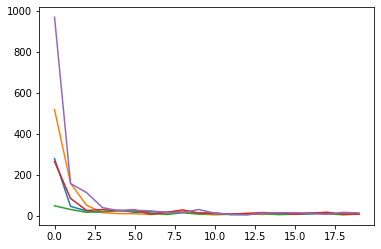

In [7]:
plt.figure()
for i in range(num_models):
    plt.plot(range(n_epochs), losses[i])
plt.show()

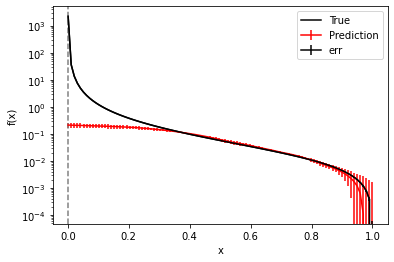

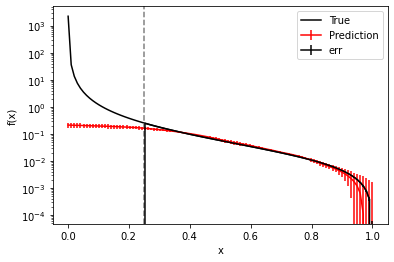

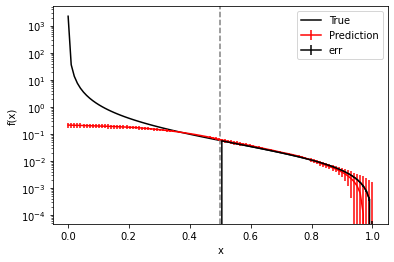

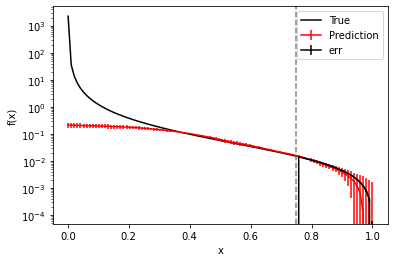

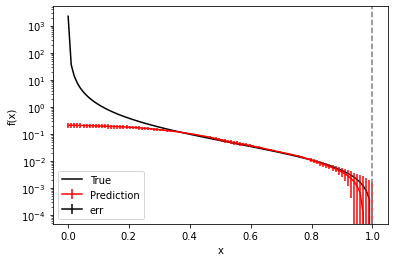

In [8]:
x_test = np.linspace(0.001, 1, 100).reshape(-1,1)    
x_test = np_to_torch(x_test, device)
y_test = f(x_test)  


x_test_cpu = x_test.detach().cpu().numpy()
y_test_cpu = y_test.detach().cpu().numpy()


Lambdas_test = [0, 0.25, 0.5, 0.75, 1]

for Lambda_test in Lambdas_test:

    y_preds = [dense_nets[i](x_test).detach().cpu().numpy() for i in range(num_models)]
    y_preds = np.array(y_preds)
    y_pred = np.mean(y_preds, axis=0)
    y_std = np.std(y_preds, axis=0)
    
    
    

    plt.figure()
    plt.plot(x_test_cpu, y_test_cpu, label='True', color = 'black')
    plt.errorbar(x_test_cpu, y_pred[:,0], yerr=y_std[:,0], label='Prediction', color='red')
    
    acceptable_error =  ((alpha_s(x_test * E0)**2)**2).detach().cpu().numpy()
    mask = x_test_cpu > Lambda_test
    
    yerr = acceptable_error*mask

    
    plt.errorbar(x_test_cpu, (y_test_cpu*mask).reshape(-1,), yerr=yerr.reshape(-1,), label='err', color='black')
    
    plt.axvline(Lambda_test, color='grey', linestyle='--')

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.yscale('log')
    plt.legend()
